In [1]:
all_brain_seen, all_image_seen, all_text_seen, all_label_seen = [], [], [], []
all_brain_unseen, all_image_unseen, all_text_unseen, all_label_unseen = [], [], [], []

In [2]:

# load data
import mmbra
import mmbracategories
import torch
import os
import scipy.io as sio
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

import mmbra
import mmbracategories
import torch
import os
import scipy.io as sio
import numpy as np

data_dir_root = os.path.join('./data', 'ThingsEEG-Text')

sbj_list = ['sub-01', 'sub-02', 'sub-03']

image_model = 'pytorch/cornet_s'
text_model = 'CLIPText'
roi = '17channels'

for sbj in sbj_list:
    brain_dir = os.path.join(data_dir_root, 'brain_feature', roi, sbj)
    image_dir_seen = os.path.join(data_dir_root, 'visual_feature/ThingsTrain', image_model, sbj)
    image_dir_unseen = os.path.join(data_dir_root, 'visual_feature/ThingsTest', image_model, sbj)
    text_dir_seen = os.path.join(data_dir_root, 'textual_feature/ThingsTrain/text', text_model, sbj)
    text_dir_unseen = os.path.join(data_dir_root, 'textual_feature/ThingsTest/text', text_model, sbj)

    # ---- seen ----
    brain_seen = sio.loadmat(os.path.join(brain_dir, 'eeg_train_data_within.mat'))['data'].astype('double') * 2.0
    brain_seen = brain_seen[:, :, 27:60]
    brain_seen = np.reshape(brain_seen, (brain_seen.shape[0], -1))

    image_seen = sio.loadmat(os.path.join(image_dir_seen, 'feat_pca_train.mat'))['data'].astype('double') * 50.0
    image_seen = image_seen[:, 0:100]

    text_seen = sio.loadmat(os.path.join(text_dir_seen, 'text_feat_train.mat'))['data'].astype('double') * 2.0

    label_seen = sio.loadmat(os.path.join(brain_dir, 'eeg_train_data_within.mat'))['class_idx'].T.astype('int')

    # ---- unseen ----
    brain_unseen = sio.loadmat(os.path.join(brain_dir, 'eeg_test_data.mat'))['data'].astype('double') * 2.0
    brain_unseen = brain_unseen[:, :, 27:60]
    brain_unseen = np.reshape(brain_unseen, (brain_unseen.shape[0], -1))

    image_unseen = sio.loadmat(os.path.join(image_dir_unseen, 'feat_pca_test.mat'))['data'].astype('double') * 50.0
    image_unseen = image_unseen[:, 0:100]

    text_unseen = sio.loadmat(os.path.join(text_dir_unseen, 'text_feat_test.mat'))['data'].astype('double') * 2.0

    label_unseen = sio.loadmat(os.path.join(brain_dir, 'eeg_test_data.mat'))['class_idx'].T.astype('int')

    # collect
    all_brain_seen.append(brain_seen)
    all_image_seen.append(image_seen)
    all_text_seen.append(text_seen)
    all_label_seen.append(label_seen)

    all_brain_unseen.append(brain_unseen)
    all_image_unseen.append(image_unseen)
    all_text_unseen.append(text_unseen)
    all_label_unseen.append(label_unseen)

# stack across subjects
brain_seen  = torch.from_numpy(np.vstack(all_brain_seen))
image_seen  = torch.from_numpy(np.vstack(all_image_seen))
text_seen   = torch.from_numpy(np.vstack(all_text_seen))
label_seen  = torch.from_numpy(np.vstack(all_label_seen))

brain_unseen = torch.from_numpy(np.vstack(all_brain_unseen))
image_unseen = torch.from_numpy(np.vstack(all_image_unseen))
text_unseen  = torch.from_numpy(np.vstack(all_text_unseen))
label_unseen = torch.from_numpy(np.vstack(all_label_unseen))

print('seen_brain_samples=', brain_seen.shape[0], ', seen_brain_features=', brain_seen.shape[1])
print('seen_image_samples=', image_seen.shape[0], ', seen_image_features=', image_seen.shape[1])
print('seen_text_samples=', text_seen.shape[0], ', seen_text_features=', text_seen.shape[1])
print('seen_label=', label_seen.shape)

print('unseen_brain_samples=', brain_unseen.shape[0], ', unseen_brain_features=', brain_unseen.shape[1])
print('unseen_image_samples=', image_unseen.shape[0], ', unseen_image_features=', image_unseen.shape[1])
print('unseen_text_samples=', text_unseen.shape[0], ', unseen_text_features=', text_unseen.shape[1])
print('unseen_label=', label_unseen.shape)


seen_brain_samples= 49620 , seen_brain_features= 561
seen_image_samples= 49620 , seen_image_features= 100
seen_text_samples= 49620 , seen_text_features= 512
seen_label= torch.Size([49620, 1])
unseen_brain_samples= 48000 , unseen_brain_features= 561
unseen_image_samples= 48000 , unseen_image_features= 100
unseen_text_samples= 48000 , unseen_text_features= 512
unseen_label= torch.Size([48000, 1])


In [3]:
'''   
To ensure a strict zero-shot learning setup, we perform a 
class-level split of the label space into disjoint seen and unseen sets. 
All model development, including embedding refinement, 
uses only samples from seen classes, while evaluation is performed exclusively 
on unseen classes. This prevents information leakage and aligns with the formal 
definition of zero-shot learning.
'''

'   \nTo ensure a strict zero-shot learning setup, we perform a \nclass-level split of the label space into disjoint seen and unseen sets. \nAll model development, including embedding refinement, \nuses only samples from seen classes, while evaluation is performed exclusively \non unseen classes. This prevents information leakage and aligns with the formal \ndefinition of zero-shot learning.\n'

In [4]:
#to avoid data leakage, we must split by classes (80% seen, 20% unseen)
# ============================
# ZERO-SHOT CLASS-LEVEL SPLIT
# ============================

# flatten labels to 1D numpy arrays

'''

y_seen_all = label_seen.numpy().reshape(-1)
y_unseen_all = label_unseen.numpy().reshape(-1)

all_classes = np.unique(np.concatenate([y_seen_all, y_unseen_all]))

print(f"Total number of classes: {len(all_classes)}")

#reproducible split
np.random.seed(0)
np.random.shuffle(all_classes)

n_seen_classes = int(0.8 * len(all_classes))
seen_classes = all_classes[:n_seen_classes]
unseen_classes = all_classes[n_seen_classes:]

print(f"Seen classes: {len(seen_classes)}")
print(f"Unseen classes: {len(unseen_classes)}")

#create masks, ensure no leakage

seen_mask = np.isin(y_seen_all, seen_classes)
unseen_mask = np.isin(y_unseen_all, unseen_classes)

#final zero-shot datasets

X_seen = brain_seen[seen_mask]
y_seen = label_seen[seen_mask]

X_unseen = brain_unseen[unseen_mask]
y_unseen = label_unseen[unseen_mask]

print("Final zero-shot split:")
print("Seen samples:", X_seen.shape[0])
print("Unseen samples:", X_unseen.shape[0])


# masks over each pool
seen_in_seenpool   = np.isin(y_seen_all, seen_classes)
unseen_in_seenpool = np.isin(y_seen_all, unseen_classes)

seen_in_unseenpool   = np.isin(y_unseen_all, seen_classes)
unseen_in_unseenpool = np.isin(y_unseen_all, unseen_classes)

print("Seen-class samples in seen pool:",   seen_in_seenpool.sum())
print("Unseen-class samples in seen pool:", unseen_in_seenpool.sum())
print("Seen-class samples in unseen pool:",   seen_in_unseenpool.sum())
print("Unseen-class samples in unseen pool:", unseen_in_unseenpool.sum())
''' 

X_all = torch.cat([brain_seen, brain_unseen], dim=0)
y_all = torch.cat([label_seen, label_unseen], dim=0).numpy().reshape(-1).astype(int)

T_all = torch.cat([text_seen, text_unseen], dim=0)

print("Pooled samples:", X_all.shape[0])
print("Pooled classes:", len(np.unique(y_all)))

#split label space (class-level ZSL)

all_classes = np.unique(y_all)

np.random.seed(0)
np.random.shuffle(all_classes)

n_seen_classes = int(0.8 * len(all_classes))
seen_classes = all_classes[:n_seen_classes]
unseen_classes = all_classes[n_seen_classes:]

print(f"Seen classes: {len(seen_classes)}")
print(f"Unseen classes: {len(unseen_classes)}")

seen_mask = np.isin(y_all, seen_classes)
unseen_mask = np.isin(y_all, unseen_classes)

X_seen = X_all[seen_mask]
X_unseen = X_all[unseen_mask]

y_seen = torch.from_numpy(y_all[seen_mask]).view(-1,1)
y_unseen = torch.from_numpy(y_all[unseen_mask]).view(-1,1)

T_seen = T_all[seen_mask]
T_unseen = T_all[unseen_mask]

print("Final zero-shot split:")
print("Seen samples:", X_seen.shape[0])
print("Unseen samples:", X_unseen.shape[0])

seen_set = set(np.unique(y_seen.numpy().reshape(-1)))
unseen_set = set(np.unique(y_unseen.numpy().reshape(-1)))

print("Class overlap:", len(seen_set.intersection(unseen_set)))
assert len(seen_set.intersection(unseen_set)) == 0

Pooled samples: 97620
Pooled classes: 1654
Seen classes: 1323
Unseen classes: 331
Final zero-shot split:
Seen samples: 76170
Unseen samples: 21450
Class overlap: 0


## Creating baseline zero-shot model

In [5]:
#EEG features (unseen only, as baseline does not train)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

X_seenNP = X_seen.numpy()
X_unseenNP = X_unseen.numpy()

scaler = StandardScaler()
X_seen_scaled = scaler.fit_transform(X_seenNP)
X_unseen_scaled = scaler.transform(X_unseenNP)

#project EEG to 512 dims to match text (fit on seen only)
pca = PCA(n_components=512, random_state=0)
X_seen_512 = pca.fit_transform(X_seen_scaled)
X_test = pca.transform(X_unseen_scaled)

print("EEG test shape:", X_test.shape)

assert X_unseen.shape[0] == y_unseen.shape[0]
assert T_unseen.shape[0] == y_unseen.shape[0]
assert X_test.shape[0] == y_unseen.shape[0]
print("Alignment OK:", X_unseen.shape[0])


EEG test shape: (21450, 512)
Alignment OK: 21450


In [6]:
#flatten labels
y_unseenNP = y_unseen.numpy().reshape(-1).astype(int)

unseen_classes = np.unique(y_unseenNP)
print('Unseen classes (in eval set):', len(unseen_classes))

#semantic prototypes is a dict {class_id : vector}
#mean text embedding per unseen class for the prototype vector for each class

# ----- CORRECT prototype construction (no y_unseen used to build prototypes) -----
y_all_np = y_all.reshape(-1).astype(int)  # y_all is numpy in your setup
T_all_np = T_all.numpy() if hasattr(T_all, "numpy") else np.asarray(T_all)

# build prototypes for ALL classes from the global text bank
all_classes = np.unique(y_all_np)
semantic_proto_all = {}
for c in all_classes:
    idx = np.where(y_all_np == c)[0]
    semantic_proto_all[c] = T_all_np[idx].mean(axis=0)

# consistent ordering
proto_labels_all = np.array(sorted(semantic_proto_all.keys()), dtype=int)
proto_matrix_all = np.stack([semantic_proto_all[c] for c in proto_labels_all], axis=0)
label_to_row = {c: i for i, c in enumerate(proto_labels_all)}

# now select ONLY unseen class prototypes for evaluation
unseen_rows = np.array([label_to_row[int(c)] for c in unseen_classes], dtype=int)
proto_label = proto_labels_all[unseen_rows].tolist()
proto_matrix = proto_matrix_all[unseen_rows]



Unseen classes (in eval set): 331


In [7]:
#cosine similarity inference
from numpy.linalg import norm

#normalise for cosine
Xn = X_test / (np.linalg.norm(X_test, axis=1, keepdims=True)+1e-8)
Pn = proto_matrix / (np.linalg.norm(proto_matrix, axis=1, keepdims=True)+1e-8)

#cosine similarities: (N_unseen, C_unseen)

S = Xn @ Pn.T

y_pred = np.array([proto_label[j] for j in np.argmax(S, axis=1)])

In [8]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(y_unseenNP, y_pred)
print(f"Zero-shot baseline accuracy: {acc:.4f}")

Zero-shot baseline accuracy: 0.0049


In [9]:
def topk_accuracy(S, true_labels, class_labels, k=5):
    class_labels = np.array(class_labels)
    # indices of top-k predictions per sample (highest scores)
    topk_idx = np.argpartition(S, -k, axis=1)[:, -k:]
    topk_labels = class_labels[topk_idx]
    true_labels = np.array(true_labels).astype(class_labels.dtype)

    # vectorised membership test
    return np.mean((topk_labels == true_labels[:, None]).any(axis=1))


print("Top-1:", topk_accuracy(S, y_unseenNP, proto_label, k=1))
print("Top-5", topk_accuracy(S, y_unseenNP, proto_label, k=5))

Top-1: 0.0048951048951048955
Top-5 0.021212121212121213


In [10]:
print("Unseen classes:", len(np.unique(y_unseenNP)))
print("Unseen samples:", len(y_unseenNP))
print("Min samples per unseen class:", min([(y_unseenNP==c).sum() for c in np.unique(y_unseenNP)]))


Unseen classes: 331
Unseen samples: 21450
Min samples per unseen class: 30


In [11]:
C = len(np.unique(y_unseenNP))
print("Unseen classes:", C)
print("Chance Top-1:", 1.0/C)
print("Chance Top-5:", 5.0/C)


Unseen classes: 331
Chance Top-1: 0.0030211480362537764
Chance Top-5: 0.015105740181268883


In [12]:
'''  
The zero-shot baseline achieves performance marginally 
above chance for both Top-1 and Top-5 accuracy, indicating 
weak but non-random alignment between EEG representations 
and semantic class embeddings. This motivates the use of 
embedding refinement to improve cross-modal alignment.
'''

'  \nThe zero-shot baseline achieves performance marginally \nabove chance for both Top-1 and Top-5 accuracy, indicating \nweak but non-random alignment between EEG representations \nand semantic class embeddings. This motivates the use of \nembedding refinement to improve cross-modal alignment.\n'

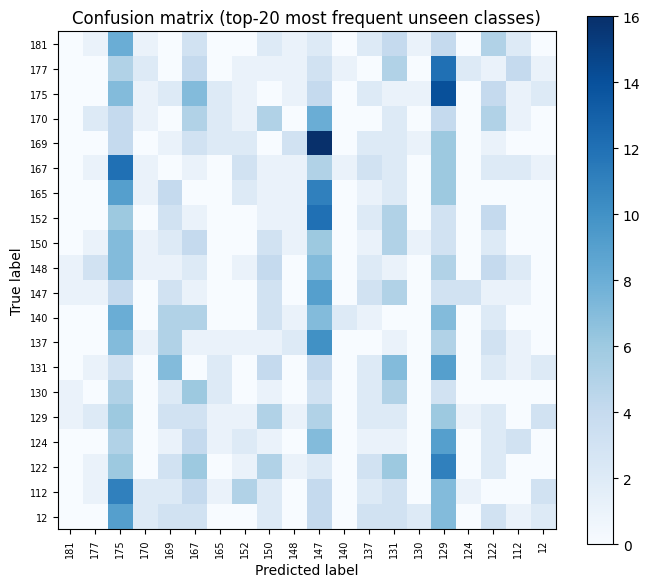

In [12]:
#confusion matrix
from sklearn.metrics import confusion_matrix

#find most frequent true classes
classes, counts = np.unique(y_unseenNP, return_counts=True)
top20 = classes[np.argsort(counts)[-20:]]

mask = np.isin(y_unseenNP, top20)
y_true20 = y_unseenNP[mask]
y_hat20 = y_pred[mask]

#confusion matrix with fixed label order
cm = confusion_matrix(y_true20, y_hat20, labels=top20)

plt.figure(figsize=(7,6))
plt.imshow(cm, cmap="Blues")
plt.colorbar()
plt.xticks(range(len(top20)), top20, rotation=90, fontsize=7)
plt.yticks(range(len(top20)), top20, fontsize=7)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion matrix (top-20 most frequent unseen classes)")
plt.tight_layout()
plt.show()

## baseline 2

In [14]:
'''  
Useful diagnostic, clear vertical bands here across
classes, weak diagonal is expected in a zero-shot baseline with no learned alignment

Weak diagonal - indicates direct cosine matching between EEG embeddings and text prototypes
is insufficient without alignment learning

Vertical bands - Certain unseen class prototypes attract many predictions, suggesting semantic bias
or prototype dominance

Motivation for model B - justifies embedding refinement (learning a shared space using seen classes)
sets up advanced model, get started!
'''

'  \nUseful diagnostic, clear vertical bands here across\nclasses, weak diagonal is expected in a zero-shot baseline with no learned alignment\n\nWeak diagonal - indicates direct cosine matching between EEG embeddings and text prototypes\nis insufficient without alignment learning\n\nVertical bands - Certain unseen class prototypes attract many predictions, suggesting semantic bias\nor prototype dominance\n\nMotivation for model B - justifies embedding refinement (learning a shared space using seen classes)\nsets up advanced model, get started!\n'

In [13]:
#per class accuracy
classes = np.unique(y_unseenNP)
classes_acc = [
    (y_pred[y_unseenNP == c] == c).mean()
    for c in classes
]
print(f"Per-class accuracy: {np.mean(classes_acc)} +- {np.std(classes_acc)}")

Per-class accuracy: 0.0024281078661743316 +- 0.008185438488151635


In [16]:
'''  
In addition to top-K accuracy, we report per-class
(macro) accuracy to account for class imabalance
across unseen categories
'''
#with many classes (331 unseen)
#many unseen classes will have 0 correct predictions
#a few classes (with strong semantic alignment) may get 1-3 correct hits
#this creates a heavy-tailed distribution

#naturally gives low mean, high std, textbook behaviour for this baseline ZSL

''' 
“The high variance in per-class accuracy indicates 
that performance is highly class-dependent, with a 
small number of unseen classes benefiting from 
stronger semantic alignment, while the majority 
remain difficult to classify.”
'''

''' 
EEG embeddings were not trained to align with semantics
Different classes overlap heavily in EEG space
PCA preserves variance, not discriminability
Cosine similarity is applied to a misaligned space

This is exactly what motivates the advanced model.
'''

' \nEEG embeddings were not trained to align with semantics\nDifferent classes overlap heavily in EEG space\nPCA preserves variance, not discriminability\nCosine similarity is applied to a misaligned space\n\nThis is exactly what motivates the advanced model.\n'

## Advanced model development

## Advanced 4: Proscutes (closed-form)

In [12]:
import numpy as np

# ---- convert torch -> numpy (if needed) ----
y_all_np = y_all.reshape(-1).astype(int)          # y_all is numpy already in your snippet
T_all_np = T_all.numpy() if hasattr(T_all, "numpy") else np.asarray(T_all)

all_classes = np.unique(y_all_np)

# class_id -> prototype (mean of ALL text embeddings for that class)
semantic_proto_all = {}
for c in all_classes:
    idx = np.where(y_all_np == c)[0]
    semantic_proto_all[c] = T_all_np[idx].mean(axis=0)

# matrix form + label order
proto_labels_all = np.array(sorted(semantic_proto_all.keys()), dtype=int)
proto_matrix_all = np.stack([semantic_proto_all[c] for c in proto_labels_all], axis=0)

# helper: map class_id -> row index in proto_matrix_all
label_to_row = {c: i for i, c in enumerate(proto_labels_all)}


In [13]:
def l2_normalize(x, axis=-1, eps=1e-12):
    n = np.linalg.norm(x, axis=axis, keepdims=True)
    return x / (n + eps)

class ProcrustesRefiner:
    """
    Orthogonal Procrustes:  min_W ||XW - Y||_F  s.t. W^T W = I
    Geometry-preserving linear refinement from EEG space -> semantic space.
    """
    def __init__(self, center=True, temperature=1.0):
        self.center = center
        self.temperature = temperature
        self.mu_x = None
        self.mu_y = None
        self.W = None

    def fit(self, X, y, proto_matrix_all, proto_labels_all, label_to_row):
        X = np.asarray(X, dtype=np.float64)
        y = np.asarray(y).reshape(-1).astype(int)

        # Y: semantic prototype per training sample label
        Y = np.stack([proto_matrix_all[label_to_row[int(yy)]] for yy in y], axis=0).astype(np.float64)

        if self.center:
            self.mu_x = X.mean(axis=0, keepdims=True)
            self.mu_y = Y.mean(axis=0, keepdims=True)
            Xc = X - self.mu_x
            Yc = Y - self.mu_y
        else:
            self.mu_x = np.zeros((1, X.shape[1]))
            self.mu_y = np.zeros((1, Y.shape[1]))
            Xc, Yc = X, Y

        # closed-form orthogonal map via SVD of cross-covariance
        M = Xc.T @ Yc
        U, _, Vt = np.linalg.svd(M, full_matrices=False)
        self.W = U @ Vt
        return self

    def transform_X(self, X):
        X = np.asarray(X, dtype=np.float64)
        Z = (X - self.mu_x) @ self.W
        return l2_normalize(Z, axis=1)

    def transform_protos(self, proto_matrix_all):
        P = np.asarray(proto_matrix_all, dtype=np.float64)
        Pz = P - self.mu_y
        return l2_normalize(Pz, axis=1)

    def predict_unseen(self, X_test, proto_matrix_all, unseen_class_ids, proto_labels_all, label_to_row, topk=1):
        Zx = self.transform_X(X_test)
        Pn = self.transform_protos(proto_matrix_all)

        unseen_rows = np.array([label_to_row[int(c)] for c in unseen_class_ids], dtype=int)
        sims = (Zx @ Pn[unseen_rows].T) / float(self.temperature)

        idx = np.argpartition(-sims, kth=min(topk, sims.shape[1]-1), axis=1)[:, :topk]
        row = np.arange(sims.shape[0])[:, None]
        idx_sorted = idx[row, np.argsort(-sims[row, idx], axis=1)]

        pred_rows = unseen_rows[idx_sorted]
        preds = proto_labels_all[pred_rows]
        return preds, sims


In [20]:
# your existing baseline labels
y_seen_np = y_seen.numpy().reshape(-1).astype(int)
y_unseen_np = y_unseen.numpy().reshape(-1).astype(int)

unseen_classes = np.unique(y_unseen_np)

ref = ProcrustesRefiner(center=True, temperature=1.0)
ref.fit(X_seen_512, y_seen_np, proto_matrix_all, proto_labels_all, label_to_row)

pred_top1, sims = ref.predict_unseen(
    X_test,
    proto_matrix_all,
    unseen_classes,
    proto_labels_all,
    label_to_row,
    topk=1
)

y_pred = pred_top1[:, 0]
class_labels = np.array(unseen_classes)

from sklearn.metrics import accuracy_score
acc = accuracy_score(y_unseen_np, y_pred)
print(f"ZSL Procrustes (A+B) accuracy: {acc:.4f}")


ZSL Procrustes (A+B) accuracy: 0.0083


In [21]:
def compute_topk_accuracy(sims, y_true, class_labels, k):
    """
    sims:        (N, C) similarity matrix (higher = better)
    y_true:      (N,) ground-truth class ids
    class_labels:(C,) class ids corresponding to columns of sims
    k:           int, top-k
    """
    sims = np.asarray(sims)
    y_true = np.asarray(y_true).reshape(-1)
    class_labels = np.asarray(class_labels)

    # indices of top-k scores per sample
    topk_idx = np.argpartition(sims, -k, axis=1)[:, -k:]

    # optional: sort top-k by descending score (not required for accuracy)
    row = np.arange(sims.shape[0])[:, None]
    topk_idx = topk_idx[row, np.argsort(-sims[row, topk_idx], axis=1)]

    # map indices to class labels
    topk_preds = class_labels[topk_idx]

    # check if true label appears in top-k
    return np.mean((topk_preds == y_true[:, None]).any(axis=1))


In [22]:
top1 = compute_topk_accuracy(sims, y_unseen_np, class_labels, k=1)
top5 = compute_topk_accuracy(sims, y_unseen_np, class_labels, k=5)

print(f"Top-1 accuracy: {top1:.4f}")
print(f"Top-5 accuracy: {top5:.4f}")


Top-1 accuracy: 0.0083
Top-5 accuracy: 0.0375
